# Notebook 43: Trishear modelling of Shijia trench site: west-central Taiwan

In this notebook, we continue testing the trishear inverse modelling implementation introduced in [notebook 42](nb42_trishear_inversion.ipynb). Our test case is based on an excellent example: a decameter-scale trench exposure of a contractional fault propagation-fold, reactivated during the 1999 Chichi earthquake in west-central Taiwan ([Lin et al., 2007](https://doi.org/10.1016/j.jsg.2007.03.017)). The data for the deformed beds is in the `data/Shijia` folder, and from top to bottom it consists of the X and Y coordinates of:

- Growth strata: [ground surface](../data/Shijia/ground.txt), [bed growth 1](../data/Shijia/bedGrowth1.txt), [bed growth 2](../data/Shijia/bedGrowth2.txt), [bed growth 3](../data/Shijia/bedGrowth3.txt), and [bed growth 4](../data/Shijia/bedGrowth4.txt).

- Pregrowth strata: [bed 5](../data/Shijia/bed5.txt), [bed 6](../data/Shijia/bed6.txt), and [bed 7](../data/Shijia/bed7.txt).

## Preliminars:

We begin by importing the necessary libraries:

In [1]:
# import required libraries
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join("..", "functions")))
from trishear_inv import simulated_annealing, restore_beds, deform_beds

Next, we read and plot the beds from top (ground surface) to bottom (bed 7):

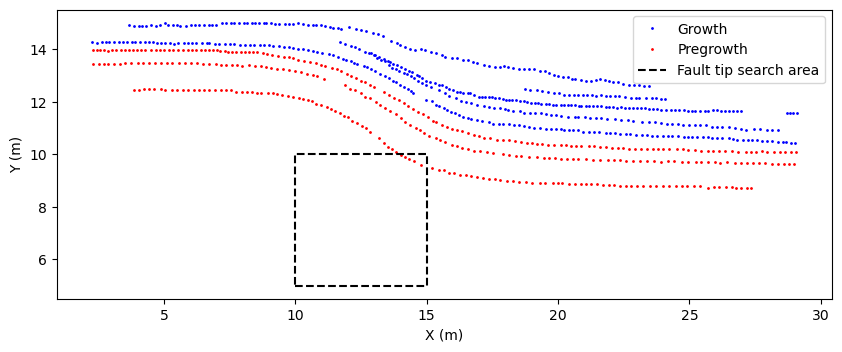

In [2]:
# read and plot the beds from top to bottom

beds = [] # list of beds
fig, ax = plt.subplots(figsize=(10, 5)) # create a figure and axis

# growth beds (0-4)
for i in range(5):
    # read the bed file
    path = os.path.join("..", "data", "Shijia", 
                        f"bedGrowth{i}.txt" if i > 0 else "ground.txt")
    bed = np.loadtxt(path)
    # plot the bed
    ax.plot(bed[:, 0], bed[:, 1], "b.", markersize=2, 
            label="Growth" if i == 0 else None)
    # add the bed to the list
    beds.append(bed)

# pregrowth beds (5-7)
for i in range(5, 8):
    # read the bed file
    path = os.path.join("..", "data", "Shijia", f"bed{i}.txt")
    bed = np.loadtxt(path)
    # plot the bed
    ax.plot(bed[:, 0], bed[:, 1], "r.", markersize=2, 
            label="Pregrowth" if i == 5 else None)
    # add the bed to the list
    beds.append(bed)
    
# plot the area where the fault tip will be searched
x_ta = [10, 15, 15, 10, 10]
y_ta = [5, 5, 10, 10, 5]
ax.plot(x_ta, y_ta, "k--", label="Fault tip search area")

ax.set_aspect("equal")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.legend()
plt.show()

## Inversion:

We will invert for the trishear parameters that best restore the pregrowth beds to straight lines. In this case, we will need to search for the six trishear parameters: X and Y location of the fault tip, ramp angle, P/S, trishear angle, and slip. We'll search for these parameters within the following ranges:

|Parameter | Start | End |
|--------- | ----- | --- |
| X tip [m] | 10 | 15 |
| T tip [m] | 5 | 10 |
| Ramp angle [°] | 25 | 45 |
| P/S | 1.0 | 3.0 |
| Trishear angle [°] | 20 | 80 |
| Slip [m] | 5 | 10 |

Using simulated annealing:

In [3]:
# simulated annealing inversion of pregrowth beds

# boundaries of the search
# max and min for each parameter
# xt, yt, ramp, ps, tra, slip, conc. factor
bounds = [(10, 15), (5, 10), (25*np.pi/180, 45*np.pi/180), (1.0, 3.0),
          (20*np.pi/180, 80*np.pi/180), (5, 10), (1.0, 1.0)]

# slip increment [m]
sinc = 0.01 

# create some lists to store the results
tpar_bests = []  # best parameters
chisq_mins = []  # minimum chi-squared values
histories = []     # history of the inversion

# Run the inversion for each pregrowth bed
# OBS: This takes a while to run.
for i in range(5, 8):
    # get the bed
    bed = beds[i]
    xp, yp = bed[:, 0], bed[:, 1] # x and y coordinates of the bed

    # start timer
    start_time = time.time()

    # run simulated annealing inversion. Use 500 cycles, and default 
    # initial temperature (5230.0), seed = None, and output = False
    tpar_best, chisq_min, history = simulated_annealing(xp, yp, bounds, sinc, 
                                                        maxiter=500)

    # end timer
    end_time = time.time()

    # elapsed time in minutes
    elapsed_time = (end_time - start_time)/60

    # print the best parameters and minimum chi-squared value
    tpar = tpar_best.copy()  # copy the best parameters
    tpar[2] = tpar[2] * 180 / np.pi # convert ramp angle to degrees
    tpar[4] = tpar[4] * 180 / np.pi # convert trishear angle to degrees
    print(f"Bed {i}: Best parameters: {np.round(tpar, 2)}, Minimum chisq: {chisq_min:.2f}, Time: {elapsed_time:.2f} min")

    # store the results
    tpar_bests.append(tpar_best)
    chisq_mins.append(chisq_min)
    histories.append(history)

Bed 5: Best parameters: [11.38  8.23 27.31  2.62 53.15 10.    1.  ], Minimum chisq: 0.12, Time: 16.04 min
Bed 6: Best parameters: [11.93  8.19 29.34  2.7  53.76  9.96  1.  ], Minimum chisq: 0.11, Time: 13.96 min
Bed 7: Best parameters: [12.22  8.26 31.53  2.68 57.    8.08  1.  ], Minimum chisq: 0.08, Time: 12.32 min


Let's look at the distribution of trishear models with chi-squared values lower than 0.5. These models do a good job restoring the beds.

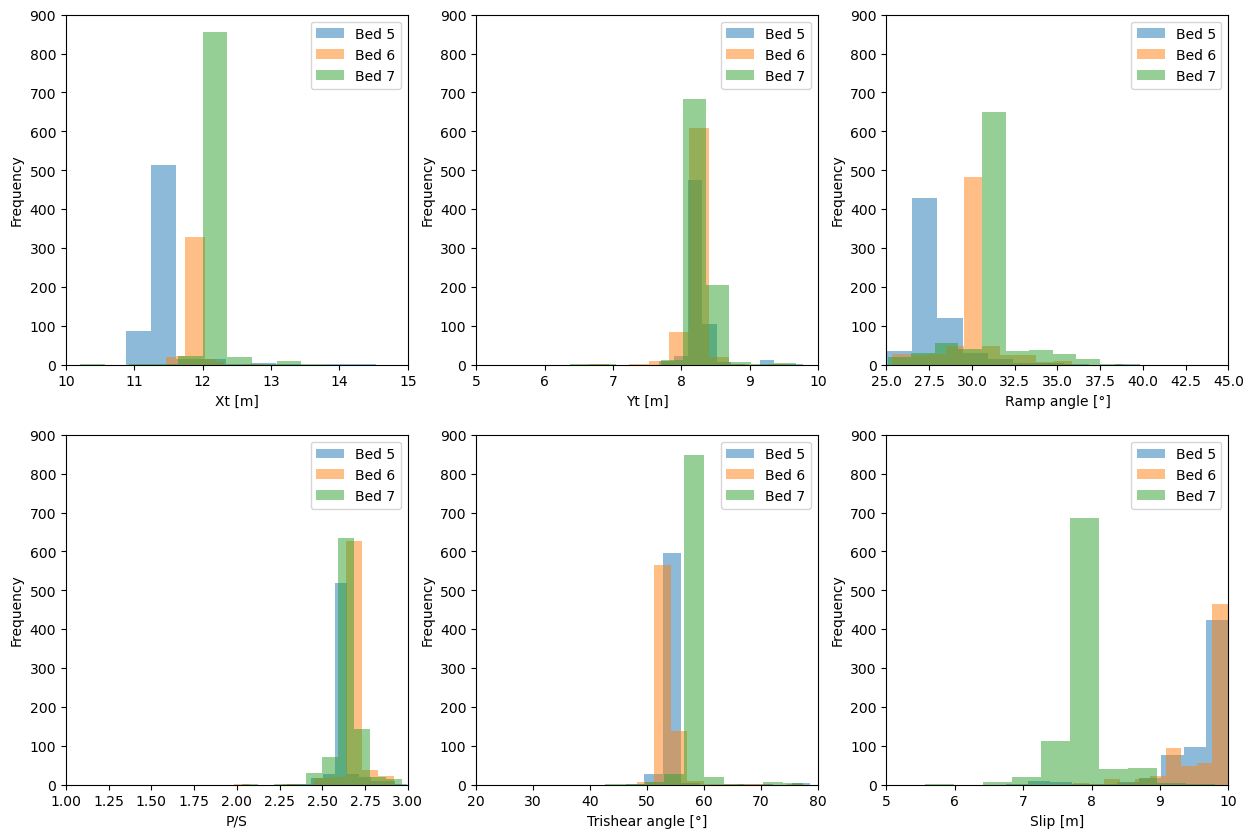

In [4]:
chisq_max = 0.5  # maximum chi-squared value to consider

# create a figure with 2 x 3 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# flatten the axes array for easier indexing
axs = axs.flatten()
# maximum limit for y-axis
max_y = 0

# for each bed, plot the histogram distribution of models
# with chi-squared values lower than chisq_max
for i in range(3):
    # get the history of the inversion
    history = histories[i]
    # get the chi-squared values
    chisq = history[:, 7]
    # get the models with chi-squared values lower than chisq_max
    mask = chisq < chisq_max
    tpar = history[mask, :6]
    tpar[:, 2] = tpar[:, 2] * 180 / np.pi  # convert ramp angle to degrees
    tpar[:, 4] = tpar[:, 4] * 180 / np.pi  # convert trishear angle to degrees
    # for each parameter
    for j in range(6):
        # plot the histogram 
        axs[j].hist(tpar[:, j], bins=10, alpha=0.5,
                    label=f"Bed {i+5}")
        # get the maximum frequency and round it to the nearest 100
        max_freq = axs[j].get_ylim()[1]
        max_freq = np.round(max_freq / 100) * 100
        # update the maximum y-axis limit if necessary
        if max_freq > max_y:
            max_y = max_freq    
    
# axes labels
labels = ["Xt [m]", "Yt [m]", "Ramp angle [°]",
          "P/S", "Trishear angle [°]", "Slip [m]"]
# axes limits
x_limits = bounds.copy()  # copy the bounds for x-axis limits
# convert ramp and trishear angles to degrees
x_limits[2] = (bounds[2][0] * 180 / np.pi, bounds[2][1] * 180 / np.pi)  
x_limits[4] = (bounds[4][0] * 180 / np.pi, bounds[4][1] * 180 / np.pi)  
# set labels, limits and legend for each subplot
for j in range(6):
    axs[j].set_xlabel(labels[j])
    axs[j].set_ylabel("Frequency")
    axs[j].set_xlim(x_limits[j])
    axs[j].set_ylim(0, max_y)
    axs[j].legend()

As you can see, there are many models that can restore the pre-growth beds. There is also some overlap between the models of the beds. Let's use the best-fit model for the lowermost pre-growth bed 7 to restore all three pre-growth beds (this is just one of the many possible options):

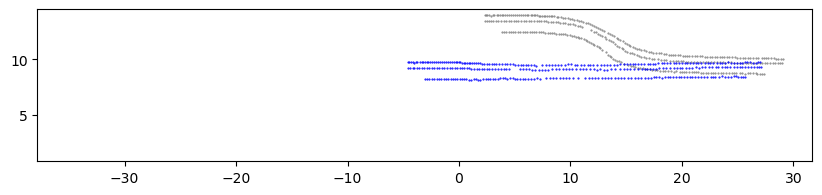

In [5]:
# restore the pre-growth beds
beds_rest, xti, yti = restore_beds(beds[5:8], tpar_bests[2], sinc, figsize=(10, 5))

Now, let's deform the beds:

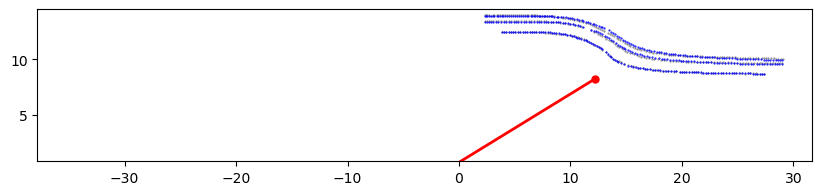

In [6]:
# trishear parameters for deforming the pre-growth beds
tpar_def = tpar_bests[2].copy()
tpar_def[0] = xti # x of initial fault tip
tpar_def[1] = yti # y of initial fault tip

# deform the beds
beds_def, xtf, ytf = deform_beds(beds_rest, beds[5:8], tpar_def, sinc, figsize=(10, 5))

We can see that the model does a good job fitting the pre-growth beds. Now let's use this model to find out the amount of fault slip for the growth strata:

In [7]:
# bounds for the growth beds
xt = tpar_bests[2][0]  # x of fault tip
yt = tpar_bests[2][1]  # y of fault tip
ramp = tpar_bests[2][2]  # ramp angle in radians
ps = tpar_bests[2][3]  # P/S ratio
tra = tpar_bests[2][4]  # trishear angle in radians
# slip is between 0.1 and 8 m
bounds = [(xt, xt), (yt, yt), (ramp, ramp), (ps, ps),
          (tra, tra), (0.1, 8), (1.0, 1.0)]

for i in range(5):
    # get the bed
    bed = beds[i]
    xp, yp = bed[:, 0], bed[:, 1]  # x and y coordinates of the bed

    # run simulated annealing inversion. Use default 100 cycles, 
    # initial temperature (5230.0), seed = None, and output = False
    tpar_best, chisq_min, history = simulated_annealing(xp, yp, bounds, sinc)

    # print the best slip and minimum chi-squared value
    print(f"Growth Bed {i}: Best slip: {tpar_best[5]:2f}, Minimum chisq: {chisq_min:.2f}")

    # store the results
    tpar_bests.append(tpar_best)
    chisq_mins.append(chisq_min)
    histories.append(history)

Growth Bed 0: Best slip: 7.528880, Minimum chisq: 1.43
Growth Bed 1: Best slip: 7.341228, Minimum chisq: 0.01
Growth Bed 2: Best slip: 6.092015, Minimum chisq: 0.22
Growth Bed 3: Best slip: 7.963336, Minimum chisq: 0.44
Growth Bed 4: Best slip: 7.946910, Minimum chisq: 0.91


From the oldest growth bed 4 to the youngest growth bed 0 (ground surface), the fault slip should decrease. Growth beds 4 and 3 have about the same slip (~ 8 m). Growth bed 2 has ~ 6 m slip. Growth beds 1 and 0 have too high slip. Growth bed 1 covers a small part of the structure, growth bed 0 (ground surface) is affected by erosion. Let's assign to growth beds 1 and 0 a slip similar to growth bed 2. Also, let's restore the growth beds:

In [ ]:
# reset the slip of growth beds 0-1 to the slip of growth bed 2
tpar_bests[3][5] = tpar_bests[5][5] # slip of growth bed 0 reset to growth bed 2
tpar_bests[4][5] = tpar_bests[5][5] # slip of growth bed 1 reset to growth bed 2

# restore the growth beds
for i in range(5):
    # restore the bed but don't plot the restoration
    bed_rest, xtig, ytig = restore_beds([beds[i]], tpar_bests[i+3], sinc, plot=False)
    beds_rest.append(bed_rest[0])
    # deform the bed but don't plot the deformation
    tpar_def = tpar_bests[i+3].copy()
    tpar_def[0] = xtig  # x of initial fault tip
    tpar_def[1] = ytig  # y of initial fault tip
    bed_def, xtf, ytf = deform_beds(bed_rest, [beds[i]], tpar_def, sinc, plot=False)
    beds_def.append(bed_def[0])

Now, let's plot the data and the model:

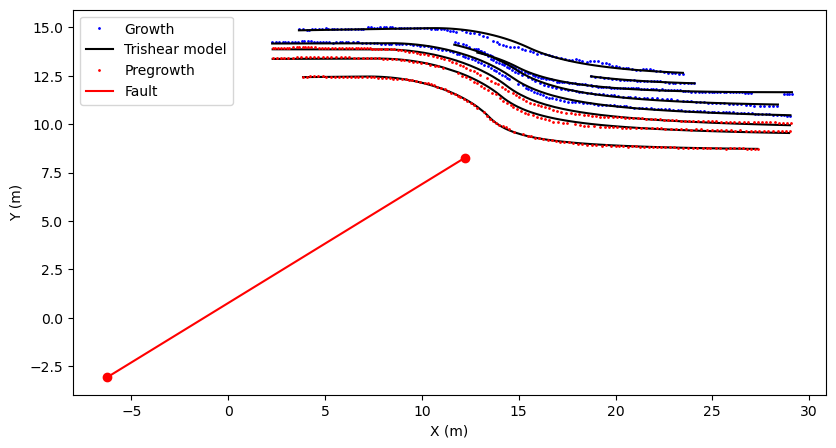

In [9]:
fig, ax = plt.subplots(figsize=(10, 5)) # create a figure and axis

for i in range(8):
    # plot the beds
    bed = beds[i]
    # growth beds (0-4)
    if i < 5:
        ax.plot(bed[:, 0], bed[:, 1], "b.", markersize=2, 
                label="Growth" if i == 0 else None)
    # pregrowth beds (5-7)
    else:
        ax.plot(bed[:, 0], bed[:, 1], "r.", markersize=2, 
                label="Pregrowth" if i == 5 else None)
    # plot the model
    bed_def = beds_def[i]
    ax.plot(bed_def[:, 0], bed_def[:, 1], "k-", markersize=2, 
            label="Trishear model" if i == 0 else None)
    
# plot the fault
x_fault = [xti, xtf]
y_fault = [yti, ytf]
ax.plot(x_fault, y_fault, "r-", label="Fault")
ax.plot(xti, yti, "ro")
ax.plot(xtf, ytf, "ro")

ax.set_aspect("equal")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.legend()
plt.show()

That is a reasonable fit to the data. However, be aware that this is just one of the many possible models that can fit the structure. [Cardozo et al., (2011)](https://doi.org/10.1016/j.jsg.2011.04.001) has a more thorough analysis of this structure, and the implications for estimating fault slip history and seismic hazard.

In [Cardozo et al., (2011)](https://doi.org/10.1016/j.jsg.2011.04.001), I used the [Matlab global optimization toolbox](https://se.mathworks.com/products/global-optimization.html) to tackle this problem. The Python implementation seems to be doing a reasonable job, although it is always challenging to sample a parameter space with many minima. I am sure my [simulated_annealing](../functions/trishear_inv.py) function can still be improved. By the way, if you run the notebook again, you may get a different result. That's because the simulated annealing search is stochastic. If you want to make it deterministic and reproducible, you will need to provide a seed to the function. 